# Wrangle and Analyse Data - WeRateDogs


## Table of Contents

- [Introduction](#intro)
- [Part I - Gathering data](#gathering)
- [Part II - Assessing Data](#assessing)
- [Part III - Cleaning Data](#cleaning)
- [Part IV - Storing, Analysing, and Visualizing Data](#analyse)


<a id='intro'></a>
## Introduction

When it comes to dealing with real-world data rarely comes clean. Using Python and its libraries, we gather data from a variety of sources and in a variety of formats, assess its quality and tidiness, then clean it. This is called data wrangling.

The dataset that I'll be wrangling (and analyzing and visualizing) is the tweet archive of Twitter user @dog_rates, also known as WeRateDogs. WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10. WeRateDogs has over 4 million followers and has received international media coverage.

WeRateDogs downloaded their Twitter archive and sent it to Udacity via email exclusively for me to use in this project. This archive contains basic tweet data (tweet ID, timestamp, text, etc.) for all 5000+ of their tweets as they stood on August 1, 2017.


<a id='probability'></a>
### Part I - Gathering Data

To get started, let's import our libraries.

In [1]:
# Load Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import tweepy 
import json
import os
import re
%matplotlib inline

 We read in the `twitter-archive-enhanced.csv` data. Store it in `df`. 


In [2]:
# Load the Twitter archive CSV file into a dataframe
archive = pd.read_csv('twitter-archive-enhanced.csv')

Download tweet image predictions using the Requests library and write it to `image_predictions.tsv`

In [3]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
with open('image-predictions.tsv', mode ='wb') as file:
    file.write(response.content)

We read in the `image-predictions.tsv` data. Store it in `df`. 


In [4]:
prediction = pd.read_csv('image-predictions.tsv', sep='\t' )

In [5]:
# Declare Twitter API keys and access tokens
consumer_key = '            '
consumer_secret = '           '
access_token = '           '
access_secret = '           '

In [6]:
# OAuth Authentication using tweepy.OAuthHandler
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

In [7]:
api = tweepy.API(auth_handler=auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

#### Help Resource : https://stackoverflow.com/questions/47612822/how-to-create-pandas-dataframe-from-twitter-search-api

In [ ]:
# tweet IDs in the Twitter archive to filter out data for each tweet

with open('getstatus_error.txt', 'w') as errfile: 
    valid_ids = 0
    err_ids = 0
    tweet_ids = archive.tweet_id
    with open('tweet_json.txt', 'w', encoding='utf-8') as outfile:
        for i, tweet_id in tweet_ids.iteritems():
            try:
                print("%s# %s" % (str(i+1), tweet_id))
                
                # Get tweet data using Twitter API
                tweet = api.get_status(tweet_id, tweet_mode='extended')
                json_content = tweet._json
                
                # Write each tweet's JSON data to its own line in a file
                json.dump(json_content, outfile)
                outfile.write('\n')
                valid_ids += 1
            except tweepy.TweepError as e:
                err_ids += 1
                err_str = []
                err_str.append(str(tweet_id))
                err_str.append(': ')
                err_str.append(e.response.json()['errors'][0]['message'])
                err_str.append('\n')
                errfile.write(''.join(err_str))
                print(''.join(err_str))
                continue
        print("%s %s" % ('Valid tweets:', valid_ids))
        print("%s %s" % ('Error tweets:', err_ids))
        

In [9]:
# List of dictionaries to read tweet's JSON data line by line and later convert to a DataFrame
tweet_data = []
with open('tweet_json.txt', 'r') as json_file:
    for line in json_file:
        data = json.loads(line)
        
        # Append to list of dictionaries
        tweet_data.append({'tweet_id': data['id'],
                        'retweet_count': data['retweet_count'],
                        'favorite_count': data['favorite_count'],
                        'display_text_range': data['display_text_range']
                       })

# Create a DataFrame with tweet ID, retweet count, favorite count and display_text_range
tweet_json = pd.DataFrame(tweet_data, columns = ['tweet_id', 'retweet_count', 'favorite_count', 'display_text_range'])

#### Part II - Assessing Data

In [10]:
# Checking structure and info about the data
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [ ]:
archive

###### Twitter archive columns:

- **tweet_id** : unique id for each tweet


- **in_reply_to_status_id** : if the represented Tweet is a reply, this field will contain the integer representation of the original Tweet’s ID


- **in_reply_to_user_id** : if the represented Tweet is a reply, this field will contain the integer representation of the original Tweet’s author ID


- **timestamp** : time when this Tweet was created


- **source** : utility used to post the Tweet, as an HTML-formatted string. e.g. Twitter for Android, Twitter for iPhone, Twitter Web Client


- **text** : actual UTF-8 text of the status update


- **retweeted_status_id**: if the represented Tweet is a retweet, this field will contain the integer representation of the original Tweet’s ID


- **retweeted_status_user_id** : if the represented Tweet is a retweet, this field will contain the integer representation of the original Tweet’s author ID


- **retweeted_status_timestamp** : time of retweet


- **expanded_urls** : tweet URL


- **rating_numerator** : numerator of the rating of a dog. 


- **rating_denominator** : denominator of the rating of a dog. Should always be 10


- **name** : name of the dog


- **doggo** : dog life "stage"


- **floofer** : dog life "stage"


- **pupper** : dog life "stage"


- **puppo** : dog life "stage"

In [12]:
pd.set_option('display.max_colwidth', -1)
archive['text']

0       This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU                                                         
1       This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV    
2       This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB                     
3       This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ                                                               
4       This is Franklin. He would like you to stop calling him "cute." He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f    
5       Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tu

Checking for correct ratings in `text` (Tweet Data)

In [13]:
archive.loc[archive['text'].str.contains(r"(\d+\.\d*\/\d+)")].text

c:\users\nilad\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


45      This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948                         
340     RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…                     
695     This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS                                 
763     This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq
1689    I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace                                                       
1712    Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD                                    

Finding duplicate values in `tweet id` 

In [14]:
sum(archive['tweet_id'].duplicated())

0

Finding retweets in `archive` in `retweet_status_id`

In [15]:
len(archive[archive['retweeted_status_id'].isnull() == False])

181

Finding missing `tweet_id` which is present in `archive` but not in `prediction` (images)

In [16]:
len(archive[~archive['tweet_id'].isin(prediction['tweet_id'])])

281

Sorting by `rating_numerator` values

In [17]:
archive['rating_numerator'].value_counts().sort_index()

0       2  
1       9  
2       9  
3       19 
4       17 
5       37 
6       32 
7       55 
8       102
9       158
10      461
11      464
12      558
13      351
14      54 
15      2  
17      1  
20      1  
24      1  
26      1  
27      1  
44      1  
45      1  
50      1  
60      1  
75      2  
80      1  
84      1  
88      1  
99      1  
121     1  
143     1  
144     1  
165     1  
182     1  
204     1  
420     2  
666     1  
960     1  
1776    1  
Name: rating_numerator, dtype: int64

In [18]:
print(archive.loc[archive['rating_numerator'] == 0, 'text'])
print(archive.loc[archive['rating_numerator'] == 121, 'text']) 
print(archive.loc[archive['rating_numerator'] == 143, 'text']) 
print(archive.loc[archive['rating_numerator'] == 144, 'text'])
print(archive.loc[archive['rating_numerator'] == 165, 'text'])
print(archive.loc[archive['rating_numerator'] == 182, 'text'])  
print(archive.loc[archive['rating_numerator'] == 204,'text']) 
print(archive.loc[archive['rating_numerator'] == 420, 'text'])
print(archive.loc[archive['rating_numerator'] == 666, 'text'])
print(archive.loc[archive['rating_numerator'] == 960, 'text'])
print(archive.loc[archive['rating_numerator'] == 1776, 'text'])

315     When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag      
1016    PUPDATE: can't see any. Even if I could, I couldn't reach them to pet. 0/10 much disappointment https://t.co/c7WXaB2nqX
Name: text, dtype: object
1635    Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55
Name: text, dtype: object
1634    Two sneaky puppers were not initially seen, moving the rating to 143/130. Please forgive us. Thank you https://t.co/kRK51Y5ac3
Name: text, dtype: object
1779    IT'S PUPPERGEDDON. Total of 144/120 ...I think https://t.co/ZanVtAtvIq
Name: text, dtype: object
902    Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE
Name: text, dtype: object
290    @markhoppus 182/10
Name: text, dtype: object
1120    Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https:/

In [19]:
# Analysing the text in corresponding columns to apprehend the rating
print(archive['text'][315])
print(archive['text'][1016])
print(archive['text'][1635])
print(archive['text'][1634])
print(archive['text'][1779])
print(archive['text'][902])
print(archive['text'][290])
print(archive['text'][1120])
print(archive['text'][188])
print(archive['text'][2074])
print(archive['text'][189])
print(archive['text'][313])
print(archive['text'][979])

When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag
PUPDATE: can't see any. Even if I could, I couldn't reach them to pet. 0/10 much disappointment https://t.co/c7WXaB2nqX
Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55
Two sneaky puppers were not initially seen, moving the rating to 143/130. Please forgive us. Thank you https://t.co/kRK51Y5ac3
IT'S PUPPERGEDDON. Total of 144/120 ...I think https://t.co/ZanVtAtvIq
Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE
@markhoppus 182/10
Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv
@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research
After so many requests... here you go.

Good dogg. 420/10 https://t.co/yfAAo1gdeY
@s8n You tried very hard to portray th

Sorting by `rating_denominator` values

In [20]:
archive['rating_denominator'].value_counts().sort_index()

0      1   
2      1   
7      1   
10     2333
11     3   
15     1   
16     1   
20     2   
40     1   
50     3   
70     1   
80     2   
90     1   
110    1   
120    1   
130    1   
150    1   
170    1   
Name: rating_denominator, dtype: int64

In [21]:
# We saw a pattern in rating while anlysing the text that in cases denominator is grater than 10  it may multiple of 10 (no of dogs * 10)
# we need to rectify the denominator value which is less than 10 or is not a multiple of 10.
print(archive.loc[archive['rating_denominator'] == 0, 'text'])
print(archive.loc[archive['rating_denominator'] == 2, 'text']) 
print(archive.loc[archive['rating_denominator'] == 7, 'text']) 
print(archive.loc[archive['rating_denominator'] == 11, 'text']) 
print(archive.loc[archive['rating_denominator'] == 15, 'text'])
print(archive.loc[archive['rating_denominator'] == 16, 'text'])

313    @jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho
Name: text, dtype: object
2335    This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv
Name: text, dtype: object
516    Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx
Name: text, dtype: object
784     RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…
1068    After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ
1662    This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5 
Name: text, dtype: object
342    @docmisterio a

In [22]:
# Analysing the text in corresponding columns to apprehend the rating
print(archive['text'][313])
print(archive['text'][2335])
print(archive['text'][516])
print(archive['text'][784])
print(archive['text'][1068])
print(archive['text'][1662])
print(archive['text'][342])
print(archive['text'][1663])

@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho
This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv
Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. 
Keep Sam smiling by clicking and sharing this link:
https://t.co/98tB8y7y7t https://t.co/LouL5vdvxx
RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…
After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ
This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5
@docmisterio account started on 11/15/15
I'm aware that I could've said 20/16, but here at WeRateDogs we are very professional. An inconsistent rating scale is simply irrespo

Checking the value counts for dog name in `name`

In [23]:
archive['name'].value_counts().sort_index()

Abby            2 
Ace             1 
Acro            1 
Adele           1 
Aiden           1 
Aja             1 
Akumi           1 
Al              1 
Albert          2 
Albus           2 
Aldrick         1 
Alejandro       1 
Alexander       1 
Alexanderson    1 
Alf             1 
Alfie           5 
Alfy            1 
Alice           2 
Amber           1 
Ambrose         1 
Amy             1 
Amélie          1 
Anakin          2 
Andru           1 
Andy            1 
Angel           1 
Anna            1 
Anthony         1 
Antony          1 
Apollo          1 
               .. 
Ziva            1 
Zoe             1 
Zoey            3 
Zooey           1 
Zuzu            1 
a               55
actually        2 
all             1 
an              7 
by              1 
getting         2 
his             1 
incredibly      1 
infuriating     1 
just            4 
life            1 
light           1 
mad             2 
my              1 
not             2 
officially      1 
old         

In [24]:
# Checking structure and info about the data
prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 119.6+ KB


In [25]:
prediction

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


###### Image Prediction columns:

- **tweet_id** : unique tweet id
- **jpg_url** : dog's image URL
- **img_num** : the image number that corresponded to the most confident prediction (numbered 1 to 4 since tweets can have up to four -images)
- **p1** : algorithm's #1 prediction for the image in the tweet
- **p1_conf** : confidence the algorithm is in its #1 prediction
- **p1_dog** : whether or not the #1 prediction is a breed of dog
- **p2** : algorithm's #2 prediction for the image in the tweet
- **p2_conf** : confidence the algorithm is in its #2 prediction
- **p2_dog** : whether or not the #2 prediction is a breed of dog
- **p3** : algorithm's #3 prediction for the image in the tweet
- **p3_conf** : confidence the algorithm is in its #3 prediction
- **p3_dog** : whether or not the #3 prediction is a breed of dog

Calculating total duplicates in `tweet_id`

In [26]:
sum(prediction['tweet_id'].duplicated())

0

Calculating total duplicates `jpg_url`

In [27]:
sum(prediction['jpg_url'].duplicated())

66

Calculating total count for each values in `img_num`

In [28]:
prediction['img_num'].value_counts()

1    1780
2    198 
3    66  
4    31  
Name: img_num, dtype: int64

Calculating different algorithm's prediction counts : `p1` , `p2` , `p3`

In [29]:
print(prediction['p1_dog'].value_counts())
print(prediction['p2_dog'].value_counts())
print(prediction['p3_dog'].value_counts())

True     1532
False    543 
Name: p1_dog, dtype: int64
True     1553
False    522 
Name: p2_dog, dtype: int64
True     1499
False    576 
Name: p3_dog, dtype: int64


In [30]:
# Checking structure and info about the data
tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2333 entries, 0 to 2332
Data columns (total 4 columns):
tweet_id              2333 non-null int64
retweet_count         2333 non-null int64
favorite_count        2333 non-null int64
display_text_range    2333 non-null object
dtypes: int64(3), object(1)
memory usage: 63.8+ KB


In [ ]:
tweet_json

###### Tweet_json columns :

- **tweet_id** : unique tweet id
- **retweet_count** : number of times tweer has been retweeted
- **favorite_count** : number of times tweet has been liked
- **display_text_range** : an array of two unicode code point indices, identifying the inclusive start and exclusive end of the displayable content of the Tweet

Checking for total duplicates `id`

In [32]:
sum(tweet_json['tweet_id'].duplicated())

0

#### Issues:

##### Tidiness Issues (3) :

- Merging the three dataframes into one using tweet_id.

- Joining the dog stages into a single column instead of four dirrent columns. doggo, floofer, pupper and puppo columns in `archive` should be merged into one column named "stage"

- If we remove duplicates from `archive` (i.e. retweets) we will have empty retweeted_status_id, retweeted_status_user_id and       retweeted_status_timestamp columns, therefor we must drop them for tidiness also there are many other useless columns in the table.



##### Quality Issues:
- Tweet_id, timestamp, sources, img_num and dog_stages need to be converted into the right datatype
- Sources column has to be filtered out to get the useful data. < href > should be removed.
- Removing the values in `name` which are not names.
- Missing values in the dog stages column showing up as 'None'
- Separate timestamp into day - month - year (3 separate columns) for making it simple and efficient.
- Removing the retweets. In text field we can easiely find that by first two letters "RT".
- In the text, we can notice some decimal numbers for the ratings numerator part wrongly extracted
- Some numerator values were higher than 10, must be rectified if not removed


### Part III - Cleaning Data

In [33]:
# Creating a copy of original data cleaned

archive_clean = archive.copy()
prediction_clean = prediction.copy()
tweet_json_clean = tweet_json.copy()

### Tidiness Issues (3) :

###### Define

###### Merging the three dataframes into one using `tweet_id`

###### Code

In [34]:
# Join archive_clean with tweet_json_clean on tweet_id
merge = pd.merge(archive_clean, tweet_json_clean, left_on = 'tweet_id', right_on = 'tweet_id', how = 'inner')

# Join merge with prediction_clean
data_clean = pd.merge(merge, prediction_clean, left_on = 'tweet_id', right_on = 'tweet_id', how = 'inner')

###### Test

In [35]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2061 entries, 0 to 2060
Data columns (total 31 columns):
tweet_id                      2061 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2061 non-null object
source                        2061 non-null object
text                          2061 non-null object
retweeted_status_id           74 non-null float64
retweeted_status_user_id      74 non-null float64
retweeted_status_timestamp    74 non-null object
expanded_urls                 2061 non-null object
rating_numerator              2061 non-null int64
rating_denominator            2061 non-null int64
name                          2061 non-null object
doggo                         2061 non-null object
floofer                       2061 non-null object
pupper                        2061 non-null object
puppo                         2061 non-null object
retweet_count                 2061 

In [ ]:
data_clean

In [37]:
# copy dataframe
archive_master = data_clean

###### Define

##### Combine dog stages into single column `stage`

###### Code

In [38]:
# Create and merge dog stages into one column
archive_master['dog_stages'] = archive_master['text'].str.extract('(doggo|floofer|pupper|puppo)', expand = True)

###### Test

In [ ]:
archive_master.head(100)

###### Define

##### Removing useless columns in `archive_master`

###### Code

In [42]:
# Delete the columns I won't be using as they shouldn't be useful in the analysis.
archive_master.drop(['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp','doggo','floofer','pupper','puppo','p1_conf','p1_dog', 'p2_conf','p2_dog', 'p3_conf','p3_dog'], axis=1, inplace=True)

###### Test

In [43]:
archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2061 entries, 0 to 2060
Data columns (total 17 columns):
tweet_id              2061 non-null int64
timestamp             2061 non-null object
source                2061 non-null object
text                  2061 non-null object
expanded_urls         2061 non-null object
rating_numerator      2061 non-null int64
rating_denominator    2061 non-null int64
name                  2061 non-null object
retweet_count         2061 non-null int64
favorite_count        2061 non-null int64
display_text_range    2061 non-null object
jpg_url               2061 non-null object
img_num               2061 non-null int64
p1                    2061 non-null object
p2                    2061 non-null object
p3                    2061 non-null object
dog_stages            335 non-null object
dtypes: int64(6), object(11)
memory usage: 201.3+ KB


### Quality Issues (8) :

In [ ]:
archive_master.head(100)

###### Define

##### Converting columns to the correct and relevant data type

###### Code

In [45]:
archive_master['tweet_id'] = archive_master['tweet_id'].astype(str)
archive_master['timestamp'] = pd.to_datetime(archive_master['timestamp'])
archive_master['source'] = archive_master['source'].astype('category')
archive_master['img_num'] = archive_master['img_num'].astype('category')
archive_master['dog_stages'] = archive_master['dog_stages'].astype('category')
archive_master['rating_numerator'] = archive_master['rating_numerator'].astype(float)
archive_master['rating_denominator'] = archive_master['rating_denominator'].astype(float)

###### Test

In [46]:
archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2061 entries, 0 to 2060
Data columns (total 17 columns):
tweet_id              2061 non-null object
timestamp             2061 non-null datetime64[ns]
source                2061 non-null category
text                  2061 non-null object
expanded_urls         2061 non-null object
rating_numerator      2061 non-null float64
rating_denominator    2061 non-null float64
name                  2061 non-null object
retweet_count         2061 non-null int64
favorite_count        2061 non-null int64
display_text_range    2061 non-null object
jpg_url               2061 non-null object
img_num               2061 non-null category
p1                    2061 non-null object
p2                    2061 non-null object
p3                    2061 non-null object
dog_stages            335 non-null category
dtypes: category(3), datetime64[ns](1), float64(2), int64(2), object(9)
memory usage: 175.4+ KB


###### Define

##### Removing useless tags from `source` i.e. < href tags >

###### Code

In [47]:
href_tags = re.compile(r'<[^>]+>')

def remove_tags(text):
    return href_tags.sub('', text)

archive_master['source'] = archive_master['source'].apply(remove_tags)

###### Test

In [ ]:
archive_master.head(100)

###### Define

##### Replacing the undesirable values in `name` by None

##### Code

In [50]:
unwantednames = ['None', 'a', 'the', 'an', 'this', 'such', 'quite', 'not', 'one', 'incredibly', 'mad', 'very', 'just', 'my']

for word in unwantednames:
    archive_master.loc[archive_master['name']  == word , 'name'] = None

##### Test

In [ ]:
archive_master.head(200)

##### Define

##### Replacing blank values by None in `dog_stages`

##### Code

In [52]:
archive_master['dog_stages'] = archive_master['dog_stages'].astype(object).replace('None', np.nan)

##### Test

In [ ]:
archive_master.head(100)

In [54]:
archive_master['dog_stages'].value_counts()

pupper     231
doggo      73 
puppo      28 
floofer    3  
Name: dog_stages, dtype: int64

##### Define

##### Separate timestamp into day - month - year (3 columns), then drop the `timestamp` column

##### Code

First we convert the timestamp to datetime and then extract year, month and day to new columns named `day`, `month` , `year` . Finally drop timestamp column.

In [55]:
# converting timestamp to datetime
archive_master['timestamp'] = pd.to_datetime(archive_master['timestamp'])

In [56]:
# appending day, month, year values to new columns
archive_master['day'] = archive_master['timestamp'].dt.day
archive_master['month'] = archive_master['timestamp'].dt.month
archive_master['year'] = archive_master['timestamp'].dt.year

In [57]:
# now we drop the unnecessary timestamp column
archive_master = archive_master.drop('timestamp', 1)

##### Test

In [ ]:
archive_master.head(300)

##### Define

##### Removing retweets. Tweets those starts with "RT" means retweets, so we need to remove them.

##### Code

In [ ]:
archive_master.loc[archive_master['text'].str.startswith('RT') != False]

In [60]:
archive_master = archive_master.loc[archive_master['text'].str.startswith('RT') == False]

##### Test

In [ ]:
archive_master

##### Define

##### Rectify ratings in numerator and denominators.


##### Code

In [62]:
# Using regex we try to find all occurences where there are more than one #/# in 'text' column
ratings_in_text = archive_master[archive_master.text.str.contains( r"(\d+\.?\d*\/\d+\.?\d*\D+\d+\.?\d*\/\d+\.?\d*)")].text

ratings_in_text

c:\users\nilad\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


605     "Yep... just as I suspected. You're not flossing." 12/10 and 11/10 for the pup not flossing https://t.co/SuXcI9B7pQ                                
814     This is Bookstore and Seaweed. Bookstore is tired and Seaweed is an asshole. 10/10 and 7/10 respectively https://t.co/eUGjGjjFVJ                   
865     After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ       
956     Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a                                                                                   
990     This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq                              
1006    Meet Travis and Flurp. Travis is pretty chill but Flurp can't lie down properly. 10/10 &amp; 8/10\nget it together Flurp https://t.co/Akzl5ynMmE   
1128    This is Socks. That water pup w the super legs just spla

In [63]:
for rate in ratings_in_text:
    mask = archive_master['text'] == rate
    archive_master.loc[mask, 'rating_numerator'] = re.findall(r"\d+\.?\d*\/\d+\.?\d*\D+(\d+\.?\d*)\/\d+\.?\d*", rate)
    archive_master.loc[mask, 'rating_denominator'] = 10

In [64]:
archive_master[archive_master['text'].isin(ratings_in_text)]

,tweet_id,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,display_text_range,jpg_url,img_num,p1,p2,p3,dog_stages,day,month,year
605,777684233540206592,Twitter for iPhone,"""Yep... just as I suspected. You're not flossing."" 12/10 and 11/10 for the pup not flossing https://t.co/SuXcI9B7pQ",https://twitter.com/dog_rates/status/777684233540206592/photo/1,11,10.0,None,3081,11704,"[0, 91]",https://pbs.twimg.com/media/CsrjryzWgAAZY00.jpg,1,cocker_spaniel,golden_retriever,otterhound,NaN,19,9,2016
814,747600769478692864,Twitter for iPhone,This is Bookstore and Seaweed. Bookstore is tired and Seaweed is an asshole. 10/10 and 7/10 respectively https://t.co/eUGjGjjFVJ,"https://twitter.com/dog_rates/status/747600769478692864/photo/1,https://twitter.com/dog_rates/status/747600769478692864/photo/1",7,10.0,Bookstore,571,2383,"[0, 104]",https://pbs.twimg.com/media/CmAC7ehXEAAqSuW.jpg,1,Chesapeake_Bay_retriever,Weimaraner,Labrador_retriever,NaN,28,6,2016
865,740373189193256964,Twitter for iPhone,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ","https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1",14,10.0,None,13679,35722,"[0, 116]",https://pbs.twimg.com/media/CkZVdJ6WYAAXZ5A.jpg,3,golden_retriever,kuvasz,Labrador_retriever,NaN,8,6,2016
956,722974582966214656,Twitter for iPhone,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,https://twitter.com/dog_rates/status/722974582966214656/photo/1,13,10.0,None,1596,4192,"[0, 40]",https://pbs.twimg.com/media/CgiFjIpWgAA4wVp.jpg,1,Great_Dane,Greater_Swiss_Mountain_dog,Weimaraner,NaN,21,4,2016
990,716439118184652801,Twitter for iPhone,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,https://twitter.com/dog_rates/status/716439118184652801/photo/1,11,10.0,Bluebert,215,2423,"[0, 117]",https://pbs.twimg.com/media/CfFNk7cWAAA-hND.jpg,1,Siberian_husky,malamute,Eskimo_dog,NaN,3,4,2016
1006,714258258790387713,Twitter for iPhone,Meet Travis and Flurp. Travis is pretty chill but Flurp can't lie down properly. 10/10 &amp; 8/10\nget it together Flurp https://t.co/Akzl5ynMmE,https://twitter.com/dog_rates/status/714258258790387713/photo/1,8,10.0,Travis,729,3089,"[0, 143]",https://pbs.twimg.com/media/CemOGNjWQAEoN7R.jpg,1,collie,Chesapeake_Bay_retriever,beagle,NaN,28,3,2016
1128,703356393781329922,Twitter for iPhone,This is Socks. That water pup w the super legs just splashed him. Socks did not appreciate that. 9/10 and 2/10 https://t.co/8rc5I22bBf,https://twitter.com/dog_rates/status/703356393781329922/photo/1,2,10.0,Socks,395,1954,"[0, 134]",https://pbs.twimg.com/media/CcLS6QKUcAAUuPa.jpg,1,Border_collie,collie,English_springer,NaN,26,2,2016
1218,695064344191721472,Twitter for iPhone,"This may be the greatest video I've ever been sent. 4/10 for Charles the puppy, 13/10 overall. (Vid by @stevenxx_) https://t.co/uaJmNgXR2P",https://twitter.com/dog_rates/status/695064344191721472/video/1,13,10.0,None,607,1637,"[0, 138]",https://pbs.twimg.com/ext_tw_video_thumb/695064251149508610/pu/img/0OPED0aUurb9Z16a.jpg,1,seat_belt,sunglasses,ice_lolly,NaN,4,2,2016
1223,694352839993344000,Twitter for iPhone,Meet Oliviér. He takes killer selfies. Has a dog of his own. It leaps at random &amp; can't bark for shit. 10/10 &amp; 5/10 https://t.co/6NgsQJuSBJ,"https://twitter.com/dog_rates/status/694352839993344000/photo/1,https://twitter.com/dog_rates/status/694352839993344000/photo/1,https://twitter.com/dog_rates/status/694352839993344000/photo/1,https://twitter.com/dog_rates/status/694352839993344000/photo/1",5,10.0,Oliviér,632,2089,"[0, 147]",https://pbs.twimg.com/media/CaLWOPfWkAAo2Dt.jpg,2,Australian_terrier,Yorks

In [65]:
# Set correct numerators for specific tweets
archive_master.loc[(archive_master['tweet_id'] == 703356393781329922) & (archive_master['rating_numerator'] == 2) , ['rating_numerator']] = 9.0
archive_master.loc[(archive_master['tweet_id'] == 694352839993344000) & (archive_master['rating_numerator'] == 5) , ['rating_numerator']] = 10.0
archive_master.loc[(archive_master['tweet_id'] == 690400367696297985) & (archive_master['rating_numerator'] == 6) , ['rating_numerator']] = 10.0
archive_master.loc[(archive_master['tweet_id'] == 674737130913071104) & (archive_master['rating_numerator'] == 4) , ['rating_numerator']] = 10.0
archive_master.loc[(archive_master['tweet_id'] == 668537837512433665) & (archive_master['rating_numerator'] == 1) , ['rating_numerator']] = 8.0
archive_master.loc[(archive_master['tweet_id'] == 667544320556335104) & (archive_master['rating_numerator'] == 4) , ['rating_numerator']] = 10.0

##### Test

In [67]:
archive_master.head(10)

,tweet_id,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,display_text_range,jpg_url,img_num,p1,p2,p3,dog_stages,day,month,year
0,892420643555336193,Twitter for iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10.0,Phineas,7978,37223,"[0, 85]",https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,bagel,banana,NaN,1,8,2017
1,892177421306343426,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10.0,Tilly,5922,32020,"[0, 138]",https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,Pekinese,papillon,NaN,1,8,2017
2,891815181378084864,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10.0,Archie,3912,24117,"[0, 121]",https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,malamute,kelpie,NaN,31,7,2017
3,891689557279858688,Twitter for iPhone,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10.0,Darla,8115,40544,"[0, 79]",https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,Labrador_retriever,spatula,NaN,30,7,2017
4,891327558926688256,Twitter for iPhone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10.0,Franklin,8809,38781,"[0, 138]",https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,English_springer,German_short-haired_pointer,NaN,29,7,2017
5,891087950875897856,Twitter for iPhone,Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13,10.0,None,2926,19485,"[0, 138]",https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1,Chesapeake_Bay_retriever,Irish_terrier,Indian_elephant,NaN,29,7,2017
6,890971913173991426,Twitter for iPhone,Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",13,10.0,Jax,1943,11373,"[0, 140]",https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,1,Appenzeller,Border_collie,ice_lolly,NaN,28,7,2017
7,890729181411237888,Twitter for iPhone,When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",13,10.0,None,17757,62813,"[0, 118]",https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,2,Pomeranian,Eskimo_dog,Pembroke,NaN,28,7,2017
8,890609185150312448,Twitter for iPhone,This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,https://twitter.com/dog_rates/status/890609185150312448/photo/1,13,10.0,Zoey,4029,26803,"[0, 122]",https://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg,1,Irish_terrier,Irish_setter,Chesapeake_Bay_retriever,NaN,27,7,2017
9,890240255349198849,Twitter for iPhone,This is Cassie. She is a college pup. Studying international doggo communication and stick theory. 14/10 so elegant much 

##### Define

##### Fix rating numerator that have decimals.

##### Code

In [68]:
# find tweets with decimals in rating in 'text' column
archive_master[archive_master['text'].str.contains(r"(\d+\.\d*\/\d+)")]

c:\users\nilad\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


,tweet_id,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,display_text_range,jpg_url,img_num,p1,p2,p3,dog_stages,day,month,year
40,883482846933004288,Twitter for iPhone,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948","https://twitter.com/dog_rates/status/883482846933004288/photo/1,https://twitter.com/dog_rates/status/883482846933004288/photo/1",5,10.0,Bella,9324,44197,"[0, 112]",https://pbs.twimg.com/media/DELC9dZXUAADqUk.jpg,1,golden_retriever,Labrador_retriever,kuvasz,NaN,8,7,2017
548,786709082849828864,Twitter for iPhone,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",https://twitter.com/dog_rates/status/786709082849828864/photo/1,75,10.0,Logan,6443,19089,"[0, 104]",https://pbs.twimg.com/media/CurzvFTXgAA2_AP.jpg,1,Pomeranian,Persian_cat,chow,NaN,13,10,2016
603,778027034220126208,Twitter for iPhone,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,https://twitter.com/dog_rates/status/778027034220126208/photo/1,27,10.0,Sophie,1703,6835,"[0, 137]",https://pbs.twimg.com/media/Cswbc2yWcAAVsCJ.jpg,1,clumber,cocker_spaniel,Lhasa,NaN,20,9,2016
1440,680494726643068929,Twitter for iPhone,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,https://twitter.com/dog_rates/status/680494726643068929/photo/1,26,10.0,None,496,1765,"[0, 106]",https://pbs.twimg.com/media/CXGaVxOWAAADjhF.jpg,1,kuvasz,Samoyed,Great_Pyrenees,pupper,25,12,2015


In [69]:
# Set correct numerators for specific tweets
archive_master.loc[(archive_master['tweet_id'] == 883482846933004288) & (archive_master['rating_numerator'] == 5), ['rating_numerator']] = 13.5
archive_master.loc[(archive_master['tweet_id'] == 786709082849828864) & (archive_master['rating_numerator'] == 75), ['rating_numerator']] = 9.75
archive_master.loc[(archive_master['tweet_id'] == 778027034220126208) & (archive_master['rating_numerator'] == 27), ['rating_numerator']] = 11.2
archive_master.loc[(archive_master['tweet_id'] == 680494726643068929) & (archive_master['rating_numerator'] == 26), ['rating_numerator']] = 11.26

##### Test

In [67]:
archive_master.head(10)

,tweet_id,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,display_text_range,jpg_url,img_num,p1,p2,p3,dog_stages,day,month,year
0,892420643555336193,Twitter for iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10.0,Phineas,7978,37223,"[0, 85]",https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,bagel,banana,NaN,1,8,2017
1,892177421306343426,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10.0,Tilly,5922,32020,"[0, 138]",https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,Pekinese,papillon,NaN,1,8,2017
2,891815181378084864,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10.0,Archie,3912,24117,"[0, 121]",https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,malamute,kelpie,NaN,31,7,2017
3,891689557279858688,Twitter for iPhone,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10.0,Darla,8115,40544,"[0, 79]",https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,Labrador_retriever,spatula,NaN,30,7,2017
4,891327558926688256,Twitter for iPhone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10.0,Franklin,8809,38781,"[0, 138]",https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,English_springer,German_short-haired_pointer,NaN,29,7,2017
5,891087950875897856,Twitter for iPhone,Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13,10.0,None,2926,19485,"[0, 138]",https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1,Chesapeake_Bay_retriever,Irish_terrier,Indian_elephant,NaN,29,7,2017
6,890971913173991426,Twitter for iPhone,Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",13,10.0,Jax,1943,11373,"[0, 140]",https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,1,Appenzeller,Border_collie,ice_lolly,NaN,28,7,2017
7,890729181411237888,Twitter for iPhone,When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",13,10.0,None,17757,62813,"[0, 118]",https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,2,Pomeranian,Eskimo_dog,Pembroke,NaN,28,7,2017
8,890609185150312448,Twitter for iPhone,This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,https://twitter.com/dog_rates/status/890609185150312448/photo/1,13,10.0,Zoey,4029,26803,"[0, 122]",https://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg,1,Irish_terrier,Irish_setter,Chesapeake_Bay_retriever,NaN,27,7,2017
9,890240255349198849,Twitter for iPhone,This is Cassie. She is a college pup. Studying international doggo communication and stick theory. 14/10 so elegant much 

### Part IV - Storing, Analysing and Visualising Data

#### Storing to csv file `twitter_archive_master.csv`

In [71]:
archive_master.to_csv('twitter_archive_master.csv', encoding='utf-8', index=False)

#### Analysing the data

In [72]:
archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1986 entries, 0 to 2060
Data columns (total 19 columns):
tweet_id              1986 non-null object
source                1986 non-null category
text                  1986 non-null object
expanded_urls         1986 non-null object
rating_numerator      1986 non-null object
rating_denominator    1986 non-null float64
name                  1354 non-null object
retweet_count         1986 non-null int64
favorite_count        1986 non-null int64
display_text_range    1986 non-null object
jpg_url               1986 non-null object
img_num               1986 non-null category
p1                    1986 non-null object
p2                    1986 non-null object
p3                    1986 non-null object
dog_stages            324 non-null object
day                   1986 non-null int64
month                 1986 non-null int64
year                  1986 non-null int64
dtypes: category(2), float64(1), int64(5), object(11)
memory usage: 198.0+ KB

In [73]:
# creating a copy
df = archive_master

##### 1.Most popular breed.

In [74]:
p1_count = df['p1'].value_counts().head(10)
p1_count

golden_retriever      139
Labrador_retriever    93 
Pembroke              88 
Chihuahua             79 
pug                   54 
chow                  41 
Samoyed               39 
Pomeranian            38 
toy_poodle            37 
malamute              29 
Name: p1, dtype: int64

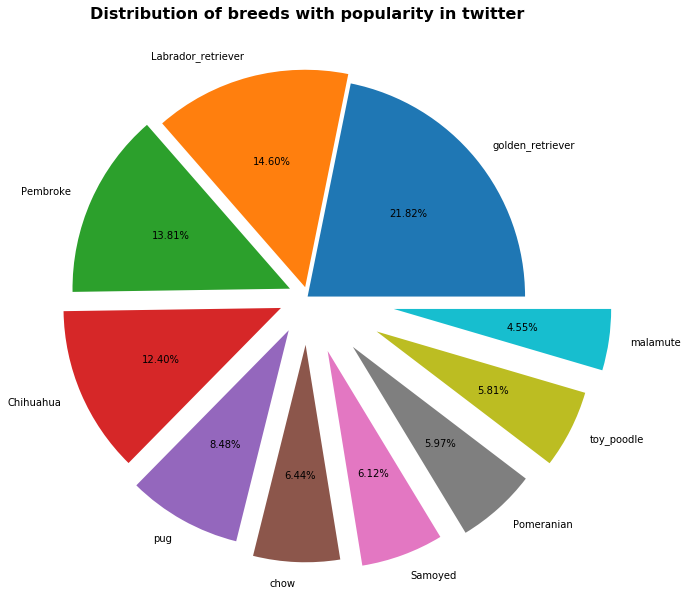

In [75]:
# Shows the repartition of the breeds with a pie chart.
explode = np.linspace(0,0.4,10)
p1_count.sort_values(ascending=False).plot.pie(legend=False, subplots=True, autopct='%.2f%%', figsize=(10,10), explode=explode)
plt.ylabel('')
plt.title('Distribution of breeds with popularity in twitter', weight='bold', fontsize=16)
plt.savefig('breed_distribution.png')

##### 2.Which source is most used when it comes to tweet.

In [76]:
sources_count = df['source'].value_counts()
sources_count

Twitter for iPhone    1948
Twitter Web Client    28  
TweetDeck             10  
Name: source, dtype: int64

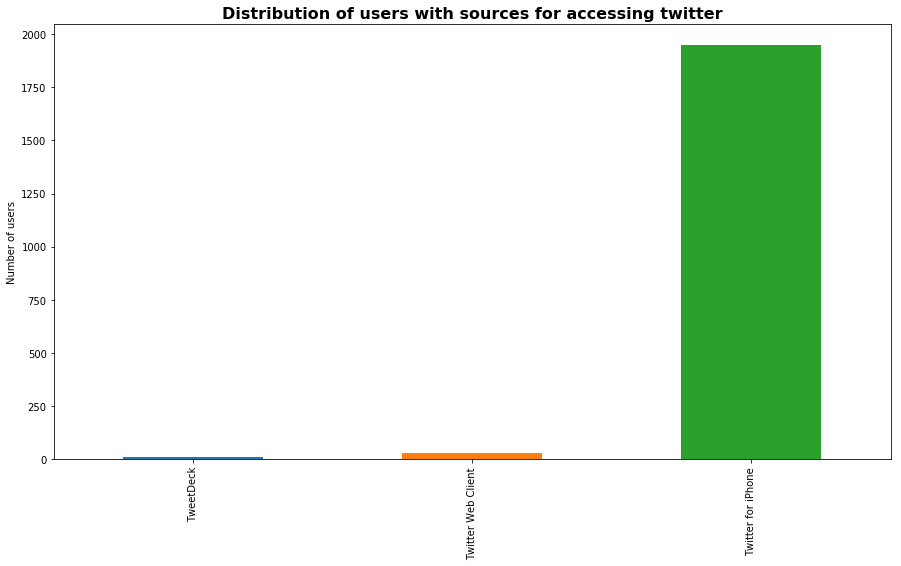

In [77]:
sources_count.sort_values().plot.bar(figsize = (15,8))
plt.ylabel('Sources')
plt.ylabel('Number of users')
plt.title('Distribution of users with sources for accessing twitter', weight='bold', fontsize=16)
plt.savefig('sources.png')

##### 3.What are the most popular names ?

In [78]:
name_count = df['name'].value_counts()
name_count.head(10)

Charlie    10
Cooper     10
Oliver     10
Penny      9 
Tucker     9 
Lucy       9 
Sadie      8 
Winston    8 
Daisy      7 
Lola       7 
Name: name, dtype: int64

##### 4.Which breed is most popular in terms of likes and retweets ?

In [79]:
# most liked dog breed
dog_favorites = df.groupby('p1')['favorite_count'].sum().sort_values(ascending=False).head(10)
dog_favorites

p1
golden_retriever      1622144
Labrador_retriever    1020104
Pembroke              954004 
Chihuahua             661889 
Samoyed               492950 
French_bulldog        448846 
chow                  390173 
pug                   300234 
cocker_spaniel        296303 
Pomeranian            291767 
Name: favorite_count, dtype: int64

In [80]:
dog_retweets = df.groupby('p1')['retweet_count'].sum().sort_values(ascending=False).head(10)
dog_retweets

p1
golden_retriever      461857
Labrador_retriever    323651
Pembroke              256657
Chihuahua             207513
Samoyed               159625
French_bulldog        110711
chow                  108050
Pomeranian            98778 
cocker_spaniel        91173 
Eskimo_dog            89817 
Name: retweet_count, dtype: int64

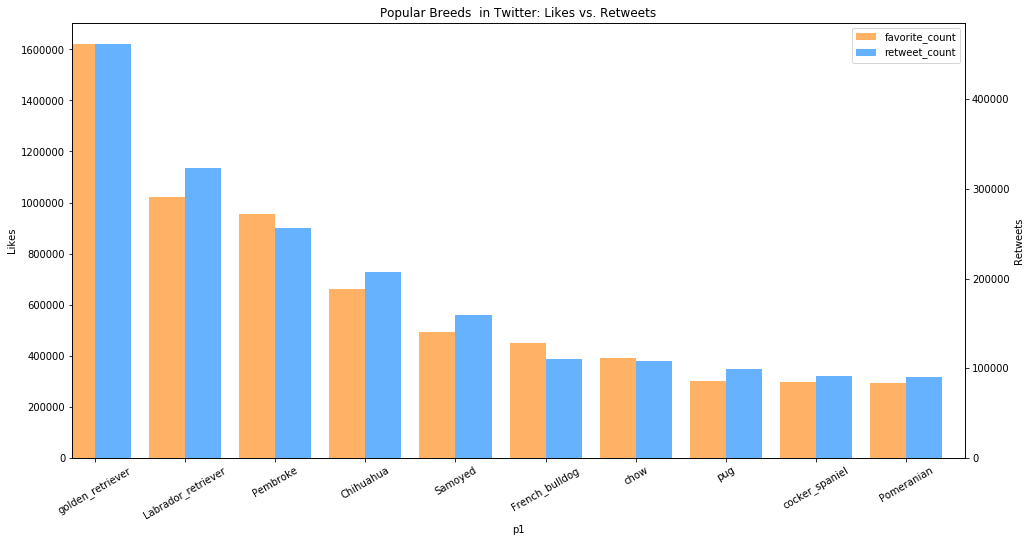

<Figure size 432x288 with 0 Axes>

In [81]:
fig = plt.figure()
ax = fig.add_subplot(111) 
ax2 = ax.twinx()

width = 0.4

dog_favorites.plot(figsize = (16,8), kind='bar', color='#FFB266', ax=ax, width=width, position=1, title='Popular Breeds  in Twitter: Likes vs. Retweets')
dog_retweets.plot(figsize = (16,8), kind='bar', color='#66B2FF', ax=ax2, width=width, position=0)

ax.grid(False)
ax2.grid(False)

ax.set_ylabel('Likes')
ax2.set_ylabel('Retweets')

ax.set_xticklabels(dog_favorites.index, rotation=30)

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2, loc=1)
plt.show()
plt.savefig('popular_breeds.png')

##### 5.Is there any corelation between likes and retweets ?

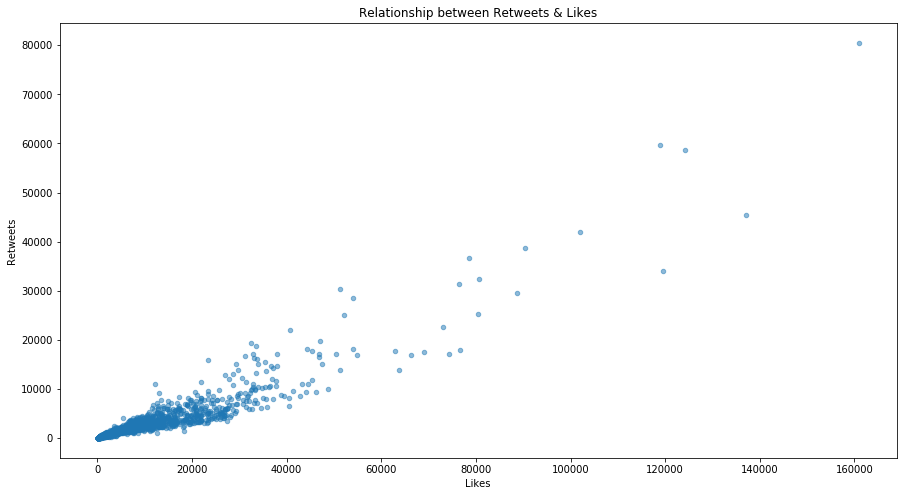

In [82]:
x = df.plot(kind = 'scatter', x = 'favorite_count', y = 'retweet_count', figsize = (15,8), alpha = 0.5)
x.grid(False)
plt.xlabel('Likes')
plt.ylabel('Retweets')
plt.title('Relationship between Retweets & Likes')
plt.savefig('likes&retweets.png')

Yes we can clearly see the positive corelation between likes and retweets.

##### 6.WeRateDogs tweeting trend over time.

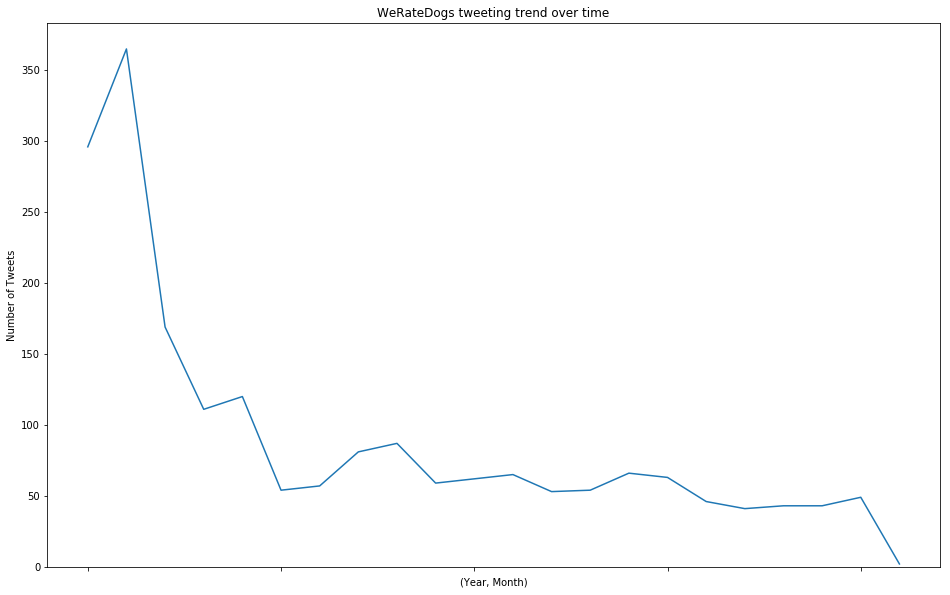

In [83]:
data = df['tweet_id'].groupby([df["year"], df["month"]]).count()
ax = data.plot('line', title='WeRateDogs tweeting trend over time', figsize = (16,10))
ax.set_xlabel("(Year, Month)")
ax.set_ylabel("Number of Tweets")
ax.set_ylim(0, )
plt.savefig('tweet_trend.png')